In [1]:
from typing import Dict, List, Tuple, Optional
import logging
import os
import json
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Activation, Concatenate, Dense, Embedding, Add, GlobalMaxPooling1D, GlobalAveragePooling1D, Dot, StringLookup
)

from types import SimpleNamespace

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

2022-09-26 09:13:37.658750: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-26 09:13:37.841684: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-26 09:13:38.466994: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cu

In [2]:
ratings_dataset, ratings_dataset_info = tfds.load(
    name='movielens/100k-ratings',
    # MovieLens dataset is not splitted into `train` and `test` sets by default.
    # So TFDS has put it all into `train` split. We load it completely and split
    # it manually.
    split='train',
    # `with_info=True` makes the `load` function return a `tfds.core.DatasetInfo`
    # object containing dataset metadata like version, description, homepage,
    # citation, etc.
    with_info=True
)


2022-09-26 09:13:41.366790: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-26 09:13:41.373788: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-09-26 09:13:41.374723: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to d

In [3]:
training_dataset = tfds.as_dataframe(ratings_dataset)

In [4]:
training_dataset.head()

,bucketized_user_age,movie_genres,movie_id,movie_title,raw_user_age,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code
0,45.0,[7],b'357',"b""One Flew Over the Cuckoo's Nest (1975)""",46.0,879024327,True,b'138',4,b'doctor',4.0,b'53211'
1,25.0,"[4, 14]",b'709',b'Strictly Ballroom (1992)',32.0,875654590,True,b'92',5,b'entertainment',2.0,b'80525'
2,18.0,[4],b'412',"b'Very Brady Sequel, A (1996)'",24.0,882075110,True,b'301',17,b'student',4.0,b'55439'
3,50.0,"[5, 7]",b'56',b'Pulp Fiction (1994)',50.0,883326919,True,b'60',4,b'healthcare',4.0,b'06472'
4,50.0,"[10, 16]",b'895',b'Scream 2 (1997)',55.0,891409199,True,b'197',18,b'technician',3.0,b'75094'


In [5]:
training_dataset.user_rating.describe()
training_dataset['user_rating'] = training_dataset['user_rating']/5.0

In [6]:
from tqdm import tqdm
tqdm.pandas()

In [7]:
import pandas as pd
training_dataset.sort_values(by='timestamp', inplace=True)
history_grouped = training_dataset.groupby('user_id').apply(lambda x:(x.movie_id.values, x.user_rating.values, x.timestamp.values)).reset_index().rename(columns={0:'user_history'})
training_dataset = pd.merge(training_dataset, history_grouped, on='user_id', how='left')

In [8]:
training_dataset['watch_history'] = training_dataset.apply(lambda x:x['user_history'][0][x['user_history'][2]<x['timestamp']][-10:], axis=1).apply(lambda x: [b'UNK']*(10-len(x)) + list(x.astype(str)) if len(x)<10 else list(x.astype(str)))
training_dataset['rating_history'] = training_dataset.apply(lambda x:x['user_history'][1][x['user_history'][2]<x['timestamp']][-10:], axis=1).apply(lambda x: [b'UNK']*(10-len(x)) + list(x) if len(x)<10 else list(x))

In [9]:
training_dataset['movie_genres'] = training_dataset['movie_genres'].apply(lambda x: ['-1']*(6-len(x)) + list(x.astype(str)) if len(x)<6 else list(x.astype(str)))

In [10]:
training_dataset['bucketized_user_age'] = training_dataset['bucketized_user_age']/training_dataset['bucketized_user_age'].max()
training_dataset['raw_user_age'] = training_dataset['raw_user_age']/training_dataset['raw_user_age'].max()
training_dataset['user_gender'] = training_dataset['user_gender'].astype(int)
training_dataset['user_occupation_label'] = training_dataset['user_occupation_label'].astype(str)

In [11]:
unique_user_ids = list(training_dataset['user_id'].unique()) + ['UNK']
unique_movie_ids = list(training_dataset['movie_id'].unique()) + ['UNK']
unique_genres = training_dataset['movie_genres'].explode().astype(str).unique()
unique_profession = training_dataset['user_occupation_label'].astype(str).unique()


embedding_dimension = 256
embedding_dimension_genre = 4

shared_user_embedding_layer = tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
shared_user_lookup_layer = tf.keras.layers.StringLookup(vocabulary=unique_user_ids, mask_token=None)

shared_movie_embedding_layer = tf.keras.layers.Embedding(len(unique_movie_ids) + 1, embedding_dimension)
shared_movie_lookup_layer = tf.keras.layers.StringLookup(vocabulary=unique_movie_ids, mask_token=None)

genre_embedding_layer = tf.keras.layers.Embedding(len(unique_genres) + 1, embedding_dimension_genre)
genre_lookup_layer = tf.keras.layers.StringLookup(vocabulary=unique_genres, mask_token=None)

profession_embedding_layer = tf.keras.layers.Embedding(len(unique_profession) + 1, embedding_dimension_genre)
profession_lookup_layer = tf.keras.layers.StringLookup(vocabulary=unique_profession, mask_token=None)

In [12]:
training_dataset.head()

,bucketized_user_age,movie_genres,movie_id,movie_title,raw_user_age,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code,user_history,watch_history,rating_history
0,0.321429,"[-1, -1, -1, -1, 4, 14]",b'255',"b""My Best Friend's Wedding (1997)""",0.287671,874724710,1,b'259',17,b'student',0.8,b'48823',"([b'255', b'286', b'298', b'185', b'173', b'10...","[b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK...","[b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK..."
1,0.321429,"[-1, -1, -1, 7, 14, 18]",b'286',"b'English Patient, The (1996)'",0.287671,874724727,1,b'259',17,b'student',0.8,b'48823',"([b'255', b'286', b'298', b'185', b'173', b'10...","[b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK...","[b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK..."
2,0.321429,"[-1, -1, -1, 0, 15, 16]",b'298',b'Face/Off (1997)',0.287671,874724754,1,b'259',17,b'student',0.8,b'48823',"([b'255', b'286', b'298', b'185', b'173', b'10...","[b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK...","[b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK..."
3,0.321429,"[-1, -1, -1, 10, 14, 16]",b'185',b'Psycho (1960)',0.287671,874724781,1,b'259',17,b'student',0.8,b'48823',"([b'255', b'286', b'298', b'185', b'173', b'10...","[b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK...","[b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK..."
4,0.321429,"[-1, -1, 0, 1, 4, 14]",b'173',"b'Princess Bride, The (1987)'",0.287671,874724843,1,b'259',17,b'student',0.8,b'48823',"([b'255', b'286', b'298', b'185', b'173', b'10...","[b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK...","[b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK..."


In [13]:
input_columns = ['bucketized_user_age','movie_id','raw_user_age','user_gender','user_id','user_occupation_label','movie_genres','watch_history']
col_tf_transforms = [tf.constant]*len(input_columns)
tensor_features = {}

training_dataset = training_dataset.to_dict('list')

for col, transform in zip(input_columns, col_tf_transforms):
    print(col)
    tensor = transform(training_dataset[col])
    tensor_features[col] = tensor

bucketized_user_age
movie_id
raw_user_age
user_gender
user_id
user_occupation_label
movie_genres
watch_history


In [14]:
import datetime
tb_logs_dir = 'logs/tensorboard_logs/'
# # Clear any logs from previous runs
# %rm -rf $tb_logs_dir

log_dir = f"{tb_logs_dir}/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [15]:
def get_user_model():
    input_user_id = tf.keras.Input(shape=(1,), dtype='string')
    input_user_id = tf.reshape(input_user_id, [-1])
    user_ids_embed = shared_user_lookup_layer(input_user_id)
    user_ids_embed = shared_user_embedding_layer(user_ids_embed)
    
    input_history = tf.keras.Input(shape=(10,), dtype='string')
    history_embed = shared_movie_lookup_layer(input_history)
    history_embed = shared_movie_embedding_layer(history_embed)
    history_flatten = tf.keras.layers.LSTM(embedding_dimension)(history_embed)
    
    input_profession = tf.keras.Input(shape=(1,), dtype='string')
    input_profession = tf.reshape(input_profession, [-1])
    profession_embed = profession_lookup_layer(input_profession)
    profession_embed = profession_embedding_layer(profession_embed)
    
    input_gender = tf.keras.Input(shape=(1,), dtype='float')
    input_raw = tf.keras.Input(shape=(1,), dtype='float')
    input_bucketized = tf.keras.Input(shape=(1,), dtype='float')
    
    combined_user_embed = tf.concat([user_ids_embed, history_flatten, profession_embed, input_gender, input_raw, input_bucketized], axis=-1)
    outputs = tf.keras.layers.Dense(embedding_dimension)(combined_user_embed)
    return tf.keras.Model(inputs=[input_user_id, input_history, input_profession, input_gender, input_raw, input_bucketized], outputs=[outputs, user_ids_embed, history_embed, profession_embed])

In [16]:
def get_movie_model():
    input_movie_ids = tf.keras.Input(shape=(1, ), dtype='string')
    input_movie_ids = tf.reshape(input_movie_ids, [-1])
    movie_ids_embed = shared_movie_lookup_layer(input_movie_ids)
    movie_ids_embed = shared_movie_embedding_layer(movie_ids_embed)
    
    input_genres = tf.keras.Input(shape=(6,), dtype='string')
    genre_embed = genre_lookup_layer(input_genres)
    genre_embed = genre_embedding_layer(genre_embed)
    genre_flattened = tf.keras.layers.GlobalAveragePooling1D()(genre_embed)
    
    
    
    combined_movie_embed = tf.concat([movie_ids_embed, genre_flattened], axis=-1)
#     combined_product_embed = tf.expand_dims(combined_product_embed, axis=-1)
    outputs = tf.keras.layers.Dense(embedding_dimension)(combined_movie_embed)

    return tf.keras.Model(inputs=[input_movie_ids, input_genres], outputs=[outputs, movie_ids_embed, genre_embed])

In [17]:
train_ds = tf.data.Dataset.from_tensor_slices(tensor_features)

movie_df = pd.DataFrame(training_dataset)[['movie_id','movie_title']].drop_duplicates()
for col, transform in zip(input_columns, col_tf_transforms):
    if col in [['movie_id','movie_title']]:
        tensor = transform(test_df[col])
        tensor_features[col] = tensor
movie_ds = tf.data.Dataset.from_tensor_slices(tensor_features)

In [18]:
class CandidateModel(tf.keras.Model):
    def __init__(self, movie_embedding):
        super().__init__()
        self._movie_embedding = movie_embedding
        # self._user_embedding = get_user_model()
        # self.retrieval_task_layer = tfrs.tasks.Retrieval(metrics=factorized_top_k_metrics)

    def call(self, inputs):
        
        # Take the input dictionary, pass it through each input layer,
        # and concatenate the result.
        movie_id = inputs['movie_id']
        genre = inputs['movie_genres']
        
        self.movie_output = self._movie_embedding([movie_id, genre])


        return self.movie_output[0]

class UserModel(tf.keras.Model):
    def __init__(self, user_embedding):
        super().__init__()
        self._user_embedding = user_embedding
        # self._user_embedding = get_user_model()
        # self.retrieval_task_layer = tfrs.tasks.Retrieval(metrics=factorized_top_k_metrics)

    def call(self, inputs):
        
        # Take the input dictionary, pass it through each input layer,
        # and concatenate the result.
        watch_history = inputs["watch_history"]
        user_id = inputs['user_id']
        #movie_id = inputs['movie_id']
        bucket_age = inputs['bucketized_user_age']
        raw_age = inputs['raw_user_age']
        profession = inputs['user_occupation_label']
        gender = inputs['user_gender']
        #genre = inputs['movie_genres']
        
        self.user_output = self._user_embedding([user_id, watch_history, profession, gender, raw_age, bucket_age])


        return self.user_output[0]

In [19]:
class QueryModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self._movie_embedding = get_movie_model()
        self._user_embedding = get_user_model()
        self.candidate_model = CandidateModel(self._movie_embedding)
        self.user_model = UserModel(self._user_embedding)
        self.factorized_top_k_metrics = tfrs.metrics.FactorizedTopK(candidates=movie_ds.batch(128).map(self.candidate_model))
        self.retrieval_task_layer = tfrs.tasks.Retrieval(metrics=self.factorized_top_k_metrics)
    

    def call(self, inputs):
        
        # Take the input dictionary, pass it through each input layer,
        # and concatenate the result.
        watch_history = inputs["watch_history"]
        user_id = inputs['user_id']
        movie_id = inputs['movie_id']
        bucket_age = inputs['bucketized_user_age']
        raw_age = inputs['raw_user_age']
        profession = inputs['user_occupation_label']
        gender = inputs['user_gender']
        genre = inputs['movie_genres']

        self.movie_output = self._movie_embedding([movie_id, genre])
        self.user_output = self._user_embedding([user_id, watch_history, profession, gender, raw_age, bucket_age])
        self.loss = self.retrieval_task_layer(
                            self.user_output[0],
                            self.movie_output[0]
                            ,compute_metrics=False  # To speed up training
                            )

        return self.loss, self.movie_output, self.user_output

In [20]:
query_model = QueryModel()


class Model(tfrs.Model):

    def __init__(self, query_model):
        super().__init__()
        self._query_model = query_model
        #self._candidate_model = candidate_model
        #self._task = task
    

    def compute_loss(self, features, training=False):

        loss, _, user_output = self._query_model(features)
        self.user_embeddings = user_output[0]
        #candidate_embedding = self._candidate_model(next_interaction)
        
        # latent cross
        # query_embedding += query_embedding * search_embedding
        
        return loss

In [21]:
model = Model(query_model)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

In [22]:
batch_size = 512
cached_train = train_ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

In [23]:
callbacks = []  # [tensorboard_callback]
model.fit(cached_train, epochs=50)

Epoch 1/50
196/196 [==============================] - 37s 174ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 2984.1011 - regularization_loss: 0.0000e+00 - total_loss: 2984.1011
Epoch 2/50
196/196 [==============================] - 33s 169ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 2821.8200 - regularization_loss: 0.0000e+00 - total_loss: 2821.8200
Epoch 3/50
196/196 [==============================] - 34s 173ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000

In [23]:
test_df = pd.DataFrame(training_dataset).head(150).tail(1).to_dict('list')

In [24]:
tensor_features = {}
for col, transform in zip(input_columns, col_tf_transforms):
    tensor = transform(test_df[col])
    tensor_features[col] = tensor

In [25]:
cache = tf.data.Dataset.from_tensor_slices(tensor_features).batch(1).cache().prefetch(tf.data.AUTOTUNE)
for batch in cache:
    data = batch
    #out = model._query_model(batch)

In [26]:
brute_force_layer = tfrs.layers.factorized_top_k.BruteForce(
    model._query_model.user_model
)

brute_force_layer.index_from_dataset(
    movie_ds.batch(128).map(lambda title: (title['movie_id'], model._query_model.candidate_model(title)))
)

In [27]:
afinity_scores, movie_ids = brute_force_layer(data)
print(f"Recommendations for user {data['user_id']} using BruteForce: {movie_ids[0, :10]}")

Recommendations for user [b'119'] using BruteForce: [b'1274' b'1274' b'1274' b'1274' b'1274' b'1274' b'1274' b'1274' b'1274'
 b'1274']


In [28]:
afinity_scores[0,0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.096436866>

In [29]:
with tf.GradientTape() as tape:
    tape.watch(data)
    loss, movie_output, user_output = model._query_model(data)
    afinity_scores, movie_ids = brute_force_layer(data)
    user = user_output[1]
    history = user_output[2]
    genre = movie_output[2]
    candidate_embedding = movie_output[0]
    full_grad = tape.gradient(afinity_scores[0,0], data)

In [30]:
pd.DataFrame(full_grad).T

,0
bucketized_user_age,0.038949
movie_id,None
raw_user_age,0.020876
user_gender,None
user_id,None
user_occupation_label,None
movie_genres,None
watch_history,None


In [31]:
with tf.GradientTape() as tape:
    tape.watch(data)
    loss, movie_output, user_output = model._query_model(data)
    afinity_scores, movie_ids = brute_force_layer(data)
    user = user_output[1]
    history = user_output[2]
    genre = movie_output[2]
    candidate_embedding = movie_output[0]
    full_grad = tape.gradient(afinity_scores[0,0], data)

with tf.GradientTape() as tape:
    query_embedding, movie_output, user_output = model._query_model(data)
    afinity_scores, movie_ids = brute_force_layer(data)
    user = user_output[1]
    history = user_output[2]
    genre = movie_output[2]
    tape.watch(user)
    user_grad = tape.gradient(query_embedding, history)
    
with tf.GradientTape() as tape:
    query_embedding, movie_output, user_output = model._query_model(data)
    afinity_scores, movie_ids = brute_force_layer(data)
    user = user_output[1]
    history = user_output[2]
    genre = movie_output[2]
    tape.watch(history)
    history_grad = tape.gradient(afinity_scores[0,0], history)
    
with tf.GradientTape() as tape:
    query_embedding, movie_output, user_output = model._query_model(data)
    afinity_scores, movie_ids = brute_force_layer(data)
    user = user_output[1]
    history = user_output[2]
    genre = movie_output[2]
    tape.watch(genre)
    genre_grad = tape.gradient(afinity_scores[0,0], genre)

In [32]:
user_grad, history_grad, genre_grad

(<tf.Tensor: shape=(1, 10, 256), dtype=float32, numpy=
 array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>,
 None,
 None)

In [33]:
import lime
import lime.lime_tabular

In [34]:
training_data = pd.DataFrame(training_dataset)
training_data[['genres_{}'.format(i) for i in range(6)]] = pd.DataFrame(training_data.movie_genres.tolist(), index= training_data.index)
training_data[['history_{}'.format(i) for i in range(10)]] = pd.DataFrame(training_data.watch_history.tolist(), index= training_data.index)

In [35]:
training_data.head()

,bucketized_user_age,movie_genres,movie_id,movie_title,raw_user_age,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,...,history_0,history_1,history_2,history_3,history_4,history_5,history_6,history_7,history_8,history_9
0,0.321429,"[-1, -1, -1, -1, 4, 14]",b'255',"b""My Best Friend's Wedding (1997)""",0.287671,874724710,1,b'259',17,b'student',...,b'UNK',b'UNK',b'UNK',b'UNK',b'UNK',b'UNK',b'UNK',b'UNK',b'UNK',b'UNK'
1,0.321429,"[-1, -1, -1, 7, 14, 18]",b'286',"b'English Patient, The (1996)'",0.287671,874724727,1,b'259',17,b'student',...,b'UNK',b'UNK',b'UNK',b'UNK',b'UNK',b'UNK',b'UNK',b'UNK',b'UNK',255
2,0.321429,"[-1, -1, -1, 0, 15, 16]",b'298',b'Face/Off (1997)',0.287671,874724754,1,b'259',17,b'student',...,b'UNK',b'UNK',b'UNK',b'UNK',b'UNK',b'UNK',b'UNK',b'UNK',255,286
3,0.321429,"[-1, -1, -1, 10, 14, 16]",b'185',b'Psycho (1960)',0.287671,874724781,1,b'259',17,b'student',...,b'UNK',b'UNK',b'UNK',b'UNK',b'UNK',b'UNK',b'UNK',255,286,298
4,0.321429,"[-1, -1, 0, 1, 4, 14]",b'173',"b'Princess Bride, The (1987)'",0.287671,874724843,1,b'259',17,b'student',...,b'UNK',b'UNK',b'UNK',b'UNK',b'UNK',b'UNK',255,286,298,185


In [36]:
continuous_features = ['bucketized_user_age','raw_user_age']
categorical_features = ['genres_{}'.format(i) for i in range(6)] + ['history_{}'.format(i) for i in range(10)] + ['user_gender', 'user_id', 'user_occupation_label','movie_id']
from sklearn.preprocessing import LabelEncoder
encoded_labels = {}
for col in categorical_features:
    encoder = LabelEncoder()
    training_data[col] = encoder.fit_transform(training_data[col].astype(str))
    encoded_labels[col] = encoder
     

In [37]:
features = continuous_features + categorical_features

In [38]:
len(features)

22

In [39]:
import lime
import lime.lime_tabular

In [40]:
profession = training_data[['user_occupation_label','user_occupation_text']].drop_duplicates()
profession_dict = dict(zip(profession.user_occupation_label, profession.user_occupation_text))
title = training_data[['movie_id','movie_title']].drop_duplicates()
title['movie_id'] = encoded_labels['movie_id'].inverse_transform(title['movie_id'])
title_dict = dict(zip(title.movie_id, title.movie_title))

def get_feature_value(df, col):
    if 'history_' in col:
        return title_dict.get("b'{}'".format(df[col].values[0]),'UNK')
    elif col=='movie_id':
        return title_dict.get(df[col].values[0],'UNK')
    elif 'occupation' in col:
        return profession_dict[df[col].astype(int).values[0]]
    else:
        return df[col].values[0]

In [62]:
import sklearn
def generate_similarity_explanations(loc = 150):
    continuous_features = ['bucketized_user_age','raw_user_age']
    categorical_features = ['genres_{}'.format(i) for i in range(6)] + ['history_{}'.format(i) for i in range(10)] + ['user_gender', 'user_id', 'user_occupation_label','movie_id']
    features = continuous_features + categorical_features
    explainer = lime.lime_tabular.LimeTabularExplainer(training_data[continuous_features + categorical_features].to_numpy(), 
                                                   feature_names=[features.index(col) for col in features], 
                                                   categorical_features=[features.index(col) for col in categorical_features], 
                                                   verbose=True, mode='regression', discretize_continuous=False)
    def get_similarity(arr):
        shape_tuple = np.shape(arr)        
        if len(shape_tuple) == 1:
            arr = arr.reshape(1, -1)
        n_rows, n_columns = arr.shape

        input_df = pd.DataFrame({features[i]:arr[:,i] for i in range(n_columns)})
        for col in categorical_features:
            input_df[col] = encoded_labels[col].inverse_transform(input_df[col].astype(int))
        input_df['movie_genres'] = input_df[['genres_{}'.format(i) for i in range(6)]].apply(lambda x:list(x.values), axis=1)
        input_df['watch_history'] = input_df[['history_{}'.format(i) for i in range(10)]].apply(lambda x:list(x.values), axis=1)
        input_df['user_gender'] = input_df['user_gender'].astype(int)
        input_df = input_df.to_dict('list')
        tensor_features = {}
        for col, transform in zip(input_columns, col_tf_transforms):
            tensor = transform(input_df[col])
            tensor_features[col] = tensor
        cache = tf.data.Dataset.from_tensor_slices(tensor_features).batch(n_rows).cache().prefetch(tf.data.AUTOTUNE)
        for batch in cache:
            data = batch
        query_embedding, movie_output, user_output = model._query_model(data)
        movie_embedding = movie_output[1].numpy()
        movie_embedding = sklearn.preprocessing.normalize(movie_embedding)
        user_embedding = user_output[1].numpy()
        user_embedding = sklearn.preprocessing.normalize(user_embedding)
        return np.diag(np.dot(movie_embedding, user_embedding.T))
    arr = training_data[continuous_features + categorical_features].to_numpy()[loc]
    similarity_score = get_similarity(arr)
    arr = training_data[continuous_features + categorical_features].to_numpy()[loc]
    exp = explainer.explain_instance(arr, get_similarity, num_features=22)
    local_explanations = exp.local_exp[1]
    shape_tuple = np.shape(arr)        
    if len(shape_tuple) == 1:
        arr = arr.reshape(1, -1)
    n_rows, n_columns = arr.shape

    input_df = pd.DataFrame({features[i]:arr[:,i] for i in range(n_columns)})
    for col in categorical_features:
        input_df[col] = encoded_labels[col].inverse_transform(input_df[col].astype(int))
    input_df['movie_genres'] = input_df[['genres_{}'.format(i) for i in range(6)]].apply(lambda x:list(x.values), axis=1)
    input_df['watch_history'] = input_df[['history_{}'.format(i) for i in range(10)]].apply(lambda x:list(x.values), axis=1)
    input_df['user_gender'] = input_df['user_gender'].astype(int)
    feature_names = [features[i] for i, score in local_explanations]
    importance = [score for i, score in local_explanations]
    feature_value = [get_feature_value(input_df, features[i]) for i, score in local_explanations]
    exp_dict = pd.DataFrame({'feature_name':feature_names,'feature_value':feature_value, 'importance_score':importance})
    return exp, exp_dict, similarity_score

def generate_top_recommendation_explanations(loc = 150):
    continuous_features = ['bucketized_user_age','raw_user_age']
    categorical_features = ['history_{}'.format(i) for i in range(10)] + ['user_gender', 'user_id', 'user_occupation_label']
    features = continuous_features + categorical_features
    explainer = lime.lime_tabular.LimeTabularExplainer(training_data[continuous_features + categorical_features].to_numpy(), class_names=[0, 1],
                                                   feature_names=[features.index(col) for col in features], 
                                                   categorical_features=[features.index(col) for col in categorical_features], 
                                                   verbose=True, mode='classification', discretize_continuous=True)    
    def get_top_movie(arr, explainations=True):
        shape_tuple = np.shape(arr)
        if len(shape_tuple) == 1:
            arr = arr.reshape(1, -1)
        n_rows, n_columns = arr.shape
        input_df = pd.DataFrame({features[i]:arr[:,i] for i in range(n_columns)})
        for col in categorical_features:
            input_df[col] = encoded_labels[col].inverse_transform(input_df[col].astype(int))
        input_df['watch_history'] = input_df[['history_{}'.format(i) for i in range(10)]].apply(lambda x:list(x.values), axis=1)
        input_df['user_gender'] = input_df['user_gender'].astype(int)
        input_df = input_df.to_dict('list')
        tensor_features = {}
        for col, transform in zip(input_columns, col_tf_transforms):
            if col in features + ['watch_history']:
                tensor = transform(input_df[col])
                tensor_features[col] = tensor
        cache = tf.data.Dataset.from_tensor_slices(tensor_features).batch(n_rows).cache().prefetch(tf.data.AUTOTUNE)
        for batch in cache:
            data = batch
        afinity_scores, movie_ids = brute_force_layer(data)
        if explainations:
            pred = np.zeros((n_rows, 2))
            out = movie_ids[:,0].numpy()
            out = (out == top_movie)#.astype(int)
            if len(out.shape)==2:
                out = out.reshape(-1,)
            pred[:,0] = out
            pred[:,1] = 1 - out
            return pred
        else:
            return movie_ids[:,0].numpy()
    arr = training_data[continuous_features + categorical_features].to_numpy()[loc]
    top_movie = get_top_movie(arr, explainations=False)#.numpy()
    arr = training_data[continuous_features + categorical_features].to_numpy()[loc]
    exp = explainer.explain_instance(arr, get_top_movie)
    local_explanations = exp.local_exp[1]
    shape_tuple = np.shape(arr)        
    if len(shape_tuple) == 1:
        arr = arr.reshape(1, -1)
    n_rows, n_columns = arr.shape

    input_df = pd.DataFrame({features[i]:arr[:,i] for i in range(n_columns)})
    for col in categorical_features:
        input_df[col] = encoded_labels[col].inverse_transform(input_df[col].astype(int))
    #input_df['movie_genres'] = input_df[['genres_{}'.format(i) for i in range(6)]].apply(lambda x:list(x.values), axis=1)
    input_df['watch_history'] = input_df[['history_{}'.format(i) for i in range(10)]].apply(lambda x:list(x.values), axis=1)
    input_df['user_gender'] = input_df['user_gender'].astype(int)
    feature_names = [features[i] for i, score in local_explanations]
    importance = [score for i, score in local_explanations]
    feature_value = [get_feature_value(input_df, features[i]) for i, score in local_explanations]
    exp_dict = pd.DataFrame({'feature_name':feature_names,'feature_value':feature_value, 'importance_score':importance})
    return exp, exp_dict, top_movie

In [63]:
exp, exps_similarity, similarity = generate_similarity_explanations(loc = 150)
exp, exps_reco, top_movie = generate_top_recommendation_explanations(loc = 150)

Intercept -0.060716361795733205
Prediction_local [-0.06071637]
Right: -0.060716372


2022-09-26 09:29:36.880895: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2000000000 exceeds 10% of free system memory.


Intercept 1.0131593809848063
Prediction_local [0.03678913]
Right: 0.0


In [64]:
exps_similarity

,feature_name,feature_value,importance_score
0,history_1,"b""It's My Party (1995)""",-2.012593e-09
1,history_7,b'Welcome to the Dollhouse (1995)',-1.319831e-09
2,history_0,"b'Time to Kill, A (1996)'",-8.815801e-10
3,movie_id,b'Dragonheart (1996)',-6.950173e-10
4,history_6,b'Phenomenon (1996)',-6.522432e-10
5,history_3,b'Twelve Monkeys (1995)',-6.139352e-10
6,history_4,b'Con Air (1997)',-5.788472e-10
7,history_2,b'Sleepers (1996)',-4.144249e-10
8,genres_0,-1,4.101851e-10
9,user_id,b'119',-2.917431e-10


In [65]:
exps_reco

,feature_name,feature_value,importance_score
0,user_gender,1,-0.283706
1,history_2,b'Sleepers (1996)',-0.252626
2,history_1,"b""It's My Party (1995)""",-0.239644
3,history_5,b'Leaving Las Vegas (1995)',0.170756
4,user_occupation_label,b'doctor',-0.155296
5,history_6,b'Phenomenon (1996)',-0.150665
6,history_0,"b'Time to Kill, A (1996)'",-0.141480
7,history_7,b'Welcome to the Dollhouse (1995)',0.082780
8,history_8,b'Independence Day (ID4) (1996)',-0.067825
9,history_4,b'Con Air (1997)',0.061334


Text(0.5, 1.0, 'Local explanation for similarity')

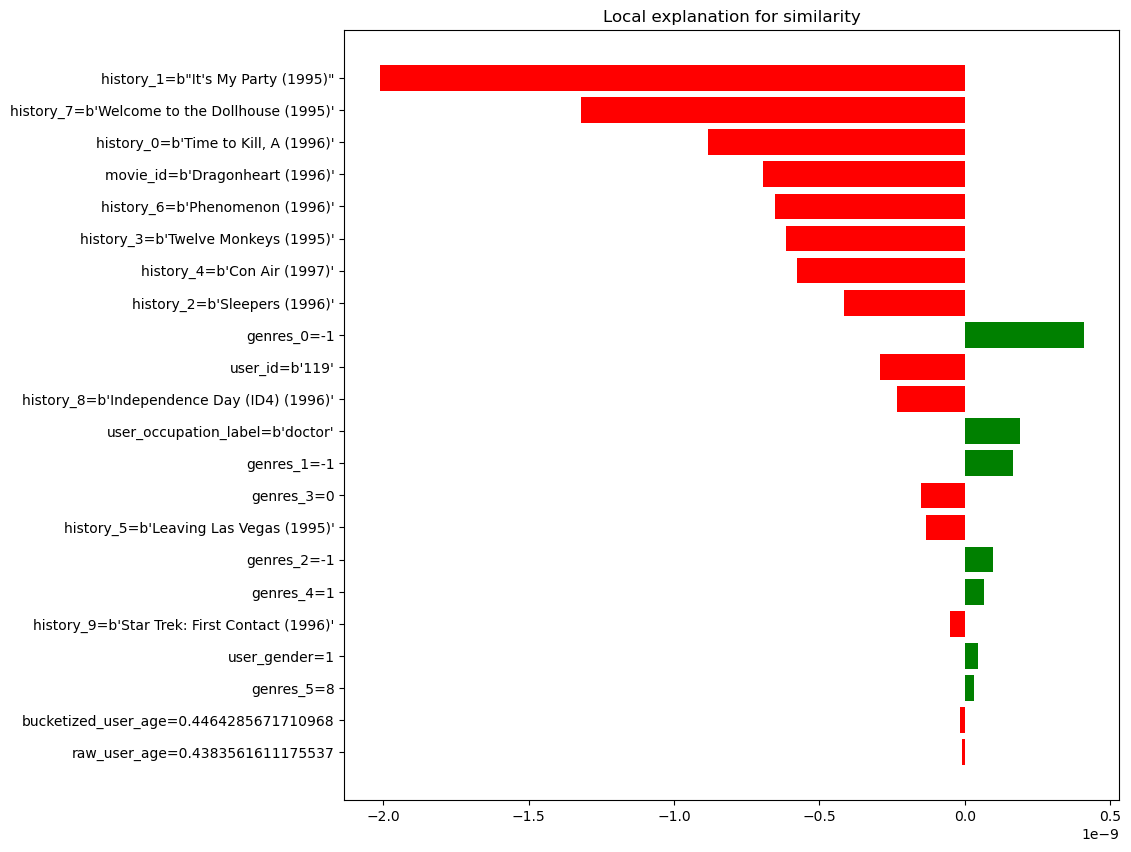

In [74]:
import matplotlib.pyplot as plt
figsize=(10,10)
exp_dict = list(exps_similarity.itertuples(index=False))
exp_tuple = [(x[0] + "=" + str(x[1]), float(x[2])) for x in exp_dict]
fig = plt.figure(figsize=figsize)
vals = [x[1] for x in exp_tuple]
names = [x[0] for x in exp_tuple]
vals.reverse()
names.reverse()
colors = ['green' if x > 0 else 'red' for x in vals]
pos = np.arange(len(exp_tuple)) + .5
plt.barh(pos, vals, align='center', color=colors)
plt.yticks(pos, names)
title = 'Local explanation for similarity'
plt.title(title)

Text(0.5, 1.0, 'Local explanation for top movie')

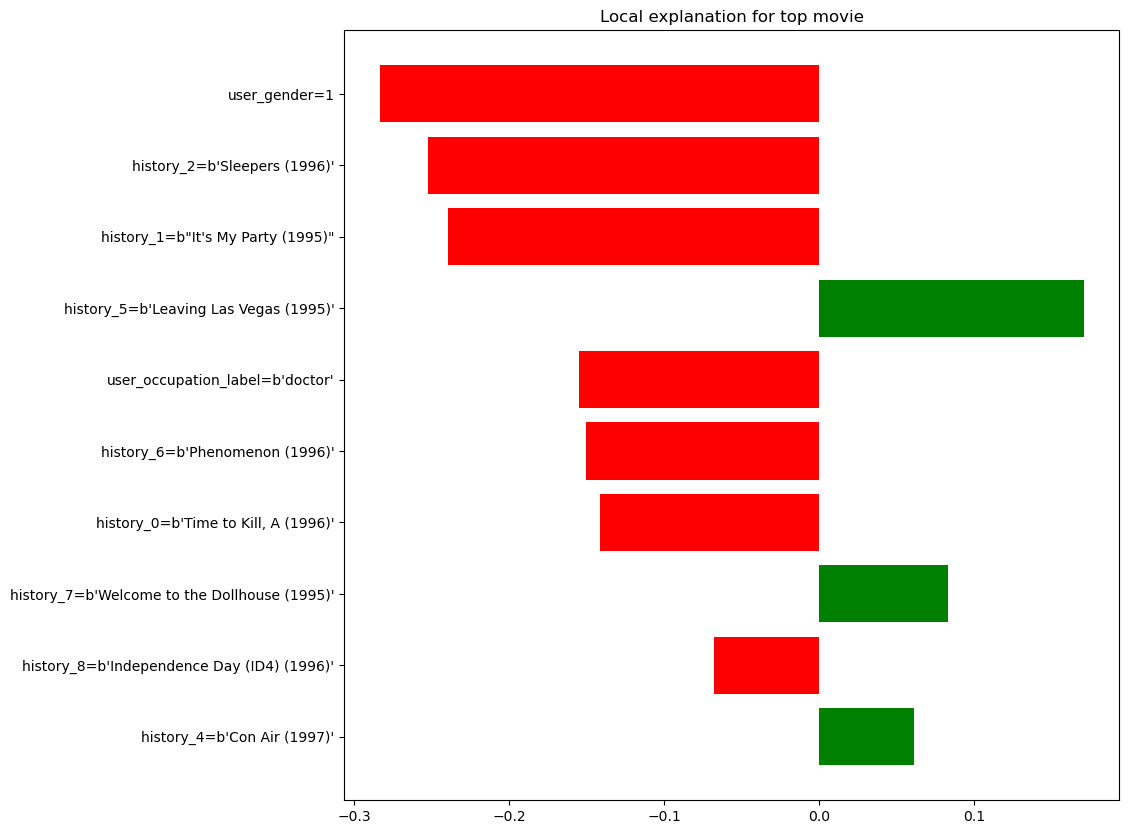

In [75]:
import matplotlib.pyplot as plt
figsize=(10,10)
exp_dict = list(exps_reco.itertuples(index=False))
exp_tuple = [(x[0] + "=" + str(x[1]), float(x[2])) for x in exp_dict]
fig = plt.figure(figsize=figsize)
vals = [x[1] for x in exp_tuple]
names = [x[0] for x in exp_tuple]
vals.reverse()
names.reverse()
colors = ['green' if x > 0 else 'red' for x in vals]
pos = np.arange(len(exp_tuple)) + .5
plt.barh(pos, vals, align='center', color=colors)
plt.yticks(pos, names)
title = 'Local explanation for top movie'
plt.title(title)

In [71]:
title_dict[str(top_movie[0])]

b'Thin Line Between Love and Hate, A (1996)'

In [73]:
training_data.iloc[150]

bucketized_user_age                                               0.446429
movie_genres                                         [-1, -1, -1, 0, 1, 8]
movie_id                                                              1097
movie_title                                          b'Dragonheart (1996)'
raw_user_age                                                      0.438356
timestamp                                                        874775406
user_gender                                                              1
user_id                                                                 22
user_occupation_label                                                    4
user_occupation_text                                         b'programmer'
user_rating                                                            0.8
user_zip_code                                                     b'67401'
user_history             ([b'300', b'286', b'322', b'323', b'458', b'86...
watch_history            